In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("/home/anukoolpurohit/Documents/Workspace/Nueromatch/NMA-DL/HandwritingBCI")

# Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import torch.nn.functional as F

In [5]:
from torch import nn
from scipy.io import loadmat
from torch.utils.data import Dataset, DataLoader, random_split

In [6]:
from handwritingBCI import Path
from handwritingBCI.data.utils.files import get_dataset
from handwritingBCI.data.utils.dataloader import get_neuro_dataloaders
from handwritingBCI.data.dataset import NeuroDataset
from handwritingBCI.data.preprocessing import LabelEncoder
from handwritingBCI.plotting import plot_electrode_data

# Setup

## Seed

In [7]:
SEED = 42
np.random.seed(SEED)

## Data

In [8]:
PATH = Path("/home/anukoolpurohit/Documents/AnukoolPurohit/Datasets/HandwritingBCI/handwriting-bci/handwritingBCIData")

# Dataset and Dataloader

In [9]:
train_dl, valid_dl = get_neuro_dataloaders(PATH,
                                           test_size=0.1,
                                           batch_size=64,
                                           generator=torch.Generator().manual_seed(SEED))

In [10]:
X, y = next(iter(train_dl))

In [11]:
X.shape, y.shape

(torch.Size([64, 1, 201, 192]), torch.Size([64]))

In [12]:
type(X.shape)

torch.Size

In [13]:
torch.Size((61, 1, 201, 192))

torch.Size([61, 1, 201, 192])

In [14]:
X.shape == (64, 1, 201, 192)

True

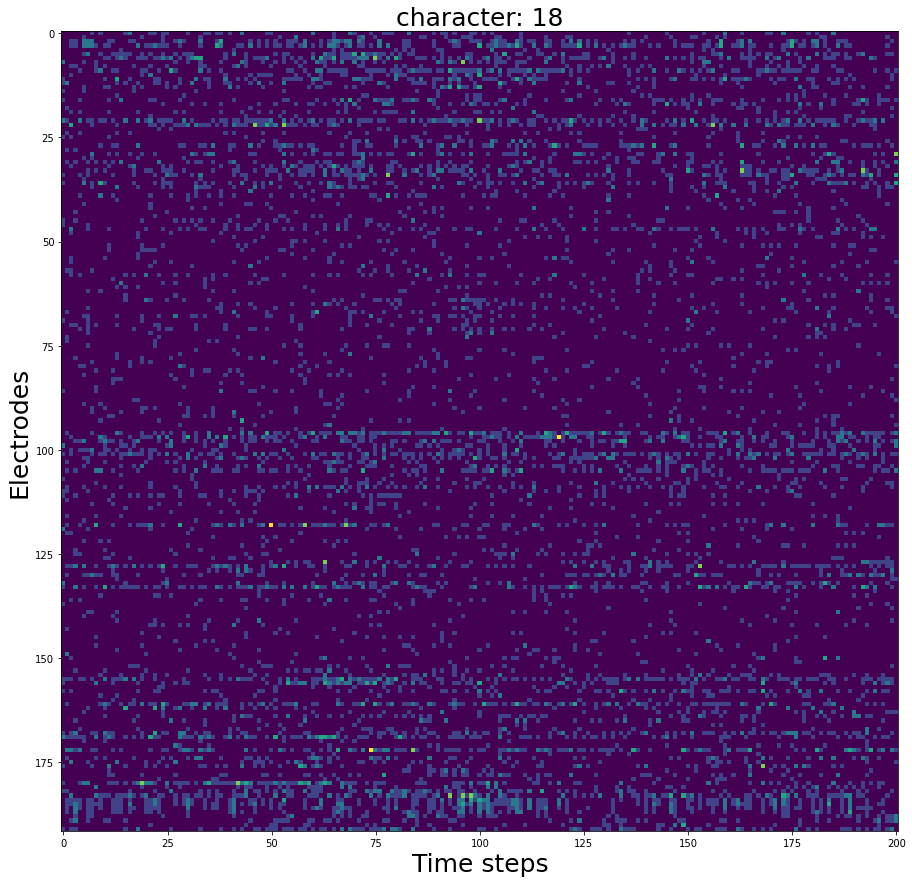

In [15]:
plot_electrode_data(X[0].squeeze(0), y[0])

## Sample model

In [16]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 7)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        return
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = F.relu(x)
        return x

In [17]:
net = SimpleCNN()

In [18]:
net(X).shape

/home/anukoolpurohit/anaconda3/envs/HandwritingBCI/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([64, 64, 22, 21])

In [19]:
len(train_dl)

52

In [20]:
data, labels = get_dataset(PATH)

In [21]:
data.shape, len(labels)

((3627, 201, 192), 3627)

In [22]:
len(valid_dl)

6